In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

with open('data/greenhouse_sensors_data.json', 'r') as file:
    data = json.load(file)['observations']

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])

sensors = [col for col in df.columns if col != 'timestamp']
n_sensors = len(sensors)
n_cols = 2
n_rows = (n_sensors + 1) // 2

display(df)

timestamp  temp_hum_1  temp_hum_2  light_1  co2_1  \
0    2025-01-01 00:00:00       18.10        76.6      0.0  567.0   
1    2025-01-01 00:05:00       17.66        81.4      0.0  614.0   
2    2025-01-01 00:10:00       18.17        76.1      0.0  577.0   
3    2025-01-01 00:15:00       17.76        72.9      6.0  599.0   
4    2025-01-01 00:20:00       18.19        69.6      7.0  580.0   
...                  ...         ...         ...      ...    ...   
4995 2025-01-18 08:15:00       25.28        62.3    924.0  300.0   
4996 2025-01-18 08:20:00       25.22        64.4    431.0  300.0   
4997 2025-01-18 08:25:00       24.75        61.4   1027.0  300.0   
4998 2025-01-18 08:30:00       26.22        65.1   1140.0  300.0   
4999 2025-01-18 08:35:00       25.01        61.7   1039.0  300.0   

      soil_moisture_1  soil_temp_1  soil_ph_1  pressure_1  ec_1  \
0                72.5        21.00       6.50      1012.8  1.90   
1                74.2        20.33       6.47      1012.7  1.98   
2                75.6        20.26       6.49      1014.3  2.02   
3                76.2        19.97       6.49      1014.7  1.98   
4                74.6        19.75       6.52      1013.3  2.08   
...               ...          ...        ...         ...   ...   
4995             88.3        21.32       6.48       990.0  2.75   
4996             86.2        21.14       6.49       990.0  2.65   
4997             87.1        21.20       6.50       990.0  2.73   
4998             85.8        21.29       6.49       990.0  2.67   
4999             86.0        21.28       6.50       990.0  2.79   

      leaf_wetness_1  
0               0.48  
1               0.47  
2               0.49  
3               0.46  
4               0.35  
...              ...  
4995            0.69  
4996            0.74  
4997            0.71  
4998            1.00  
4999            0.75  

[5000 rows x 11 columns]

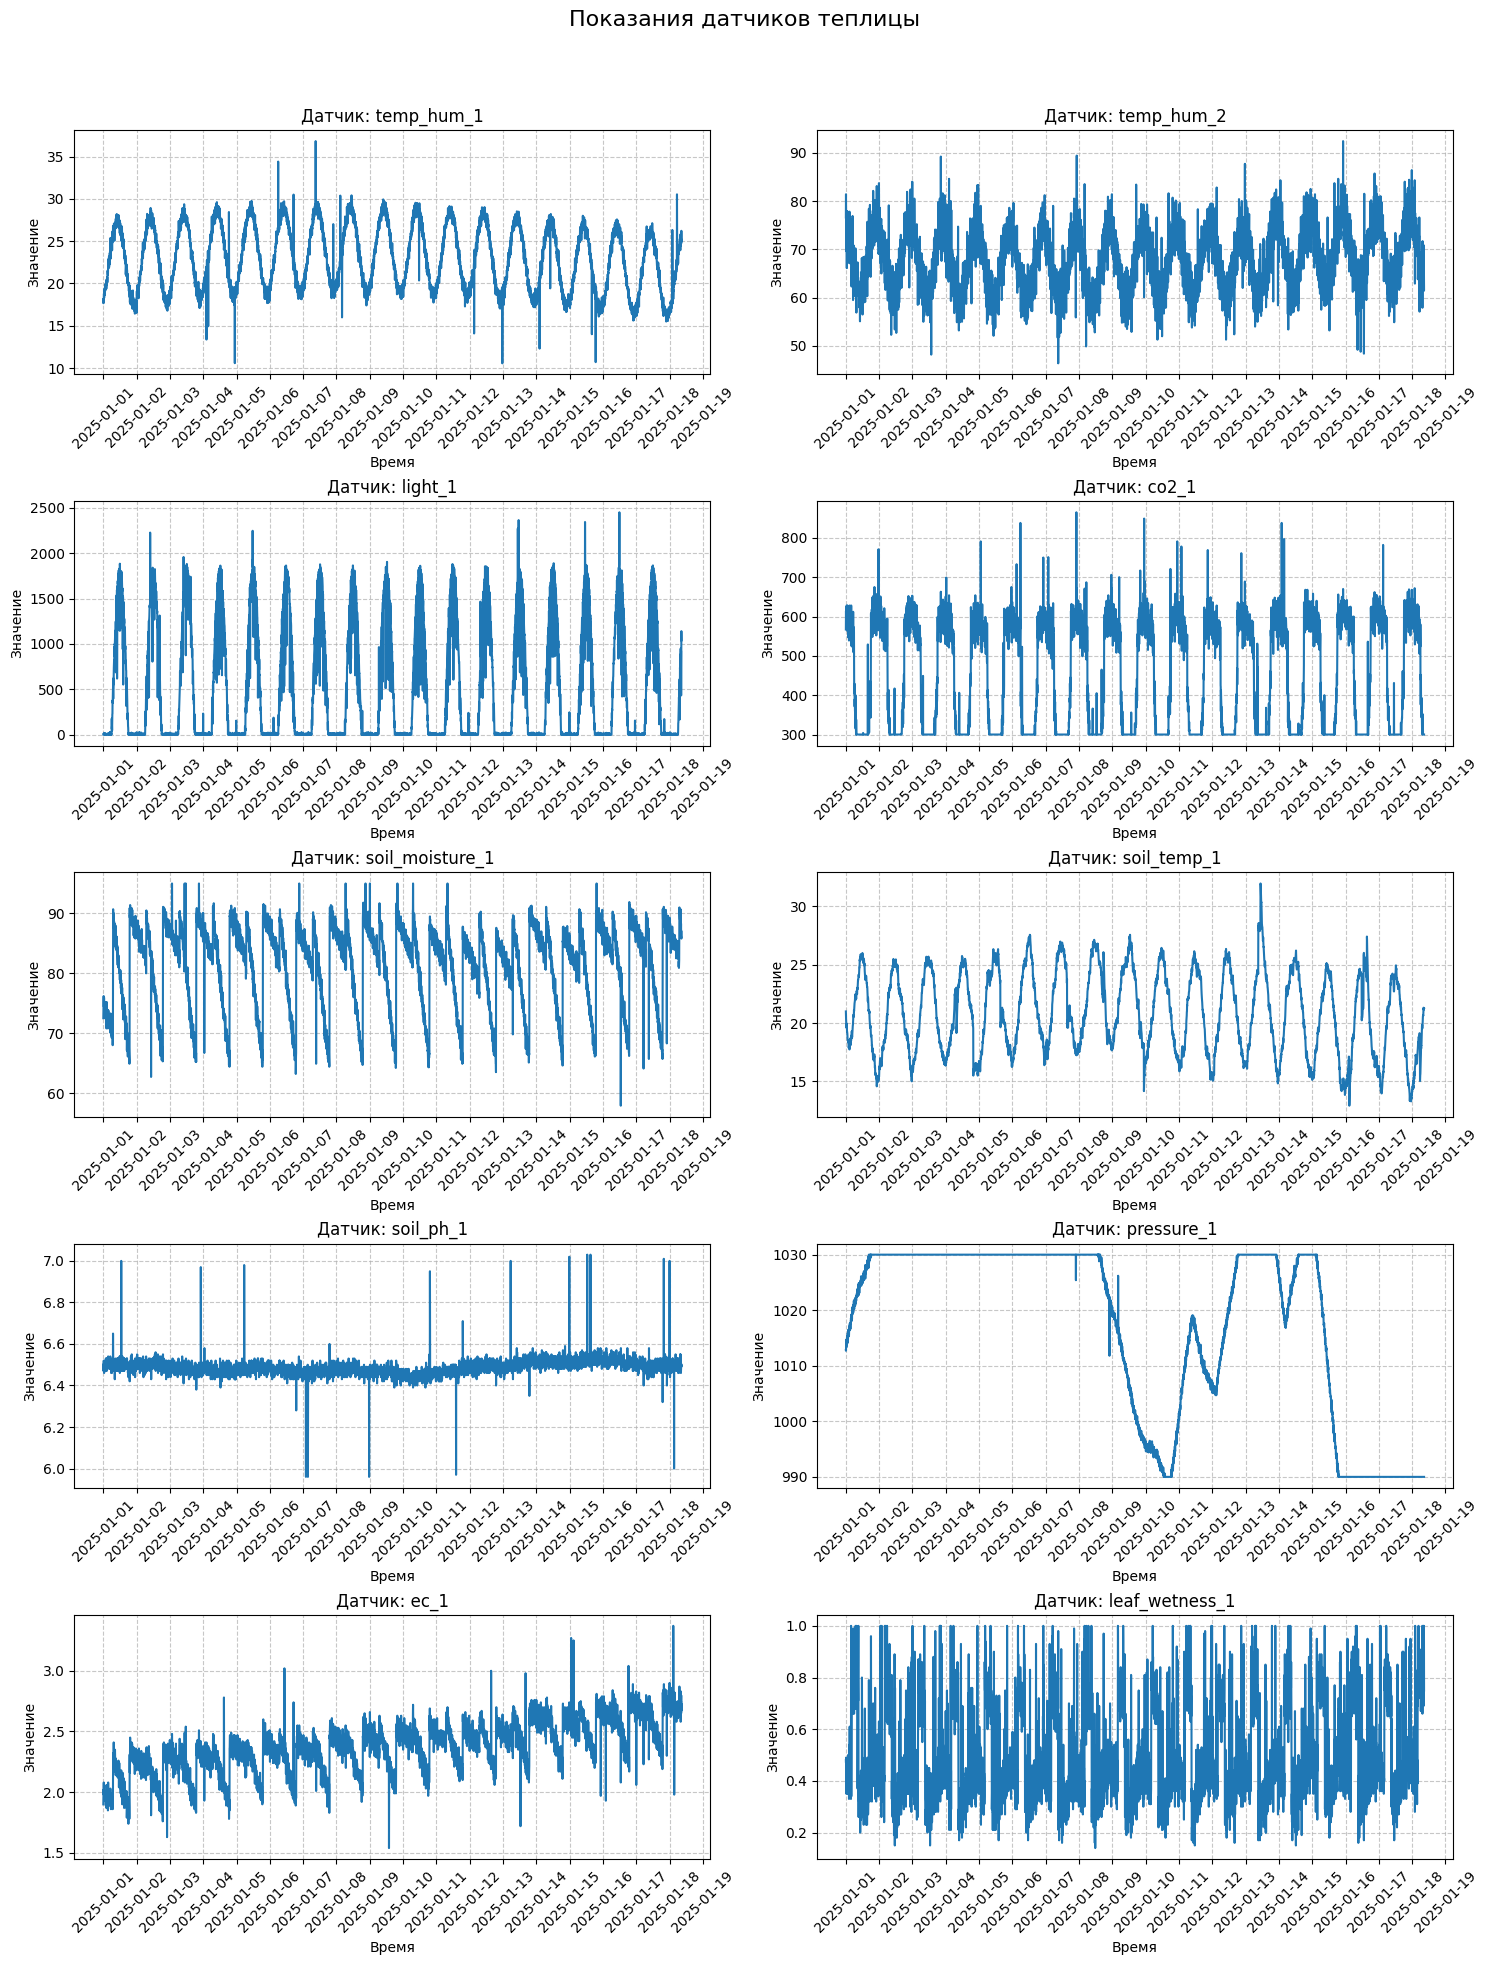

In [2]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
fig.suptitle('Показания датчиков теплицы', fontsize=16)

axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, sensor in enumerate(sensors):
    ax = axes[i]
    ax.plot(df['timestamp'], df[sensor], linewidth=1.5)
    ax.set_title(f'Датчик: {sensor}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Значение')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

for i in range(n_sensors, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Обучение нейросети LSTM

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scipy.ndimage import gaussian_filter1d
import joblib

df = df.sort_values('timestamp')

sensor_columns = [col for col in df.columns if col != 'timestamp']
sensor_data = df[sensor_columns].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sensor_data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, :])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

num_sensors = len(sensor_columns)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, num_sensors), 
         kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(25, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(num_sensors)
])

model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss='mean_squared_error'
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,
    restore_best_weights=True, 
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=60,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

C:\Users\maxik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.7366 - val_loss: 1.8654
Epoch 2/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.6793 - val_loss: 1.1832
Epoch 3/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 1.0702 - val_loss: 0.7662
Epoch 4/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.6966 - val_loss: 0.5058
Epoch 5/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4637 - val_loss: 0.3428
Epoch 6/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.3162 - val_loss: 0.2386
Epoch 7/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2212 - val_loss: 0.1709
Epoch 8/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1597 - val_loss: 0.1257
Epoch 9/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1176 - val_loss: 0.0978
Epoch 10/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0920 - val_loss: 0.0739
Epoch 11/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0699 - val_loss: 0.0594
Epoch 12/60
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0

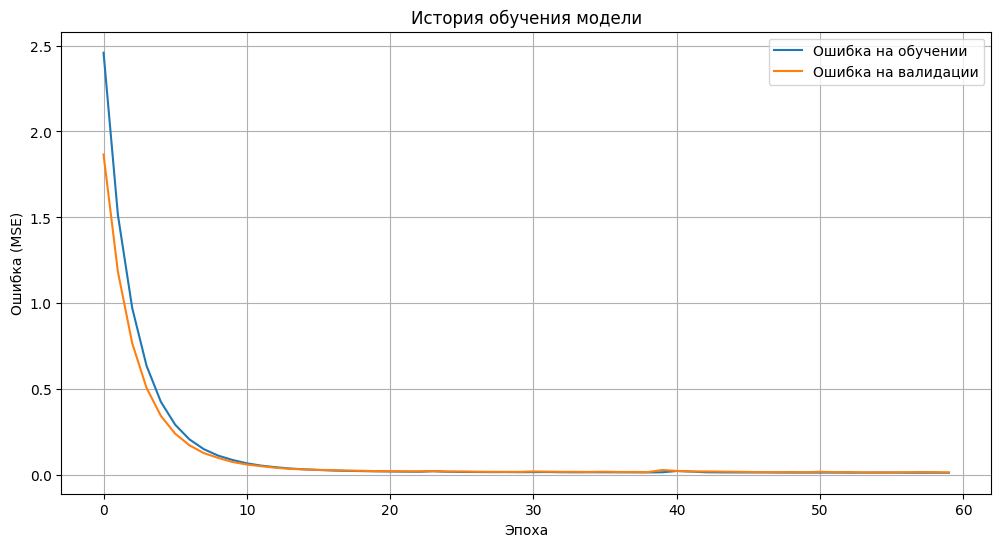

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('История обучения модели')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Получение предсказаний
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Вычисление метрик
metrics_data = []
for i, sensor_name in enumerate(sensor_columns):
    mse = np.mean((predictions_inverse[:, i] - y_test_inverse[:, i])**2)
    mae = np.mean(np.abs(predictions_inverse[:, i] - y_test_inverse[:, i]))
    rmse = np.sqrt(mse)
    
    non_zero = (np.abs(y_test_inverse[:, i]) > 1e-10)
    mape = np.mean(np.abs((y_test_inverse[non_zero, i] - predictions_inverse[non_zero, i]) / 
                          y_test_inverse[non_zero, i])) * 100
    
    min_val = np.min(y_test_inverse[:, i])
    max_val = np.max(y_test_inverse[:, i])
    
    metrics_data.append({
        'Датчик': sensor_name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'Min': min_val,
        'Max': max_val
    })

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
         Датчик        MSE      MAE     RMSE  MAPE (%)      Min       Max
     temp_hum_1     4.6562   1.7694   2.1578    9.1755  10.7000   30.5300
     temp_hum_2    21.4890   3.6494   4.6356    5.1065  48.4000   92.4000
        light_1 66042.5618 159.7179 256.9875  191.9039   0.0000 2451.0000
          co2_1  2946.4341  42.2875  54.2811   10.7582 300.0000  782.0000
soil_moisture_1    17.0868   2.8265   4.1336    3.5793  57.9000   95.0000
    soil_temp_1     5.3464   1.8642   2.3122   10.9867  12.9200   27.4200
      soil_ph_1     0.0054   0.0578   0.0734    0.8842   6.0000    7.0300
     pressure_1    56.5723   7.1574   7.5215    0.7201 990.0000 1030.0000
           ec_1     0.0638   0.2367   0.2526    9.0422   1.9300    3.3700
 leaf_wetness_1     0.0216   0.1040   0.1468   20.1204   0.1600    1.0000


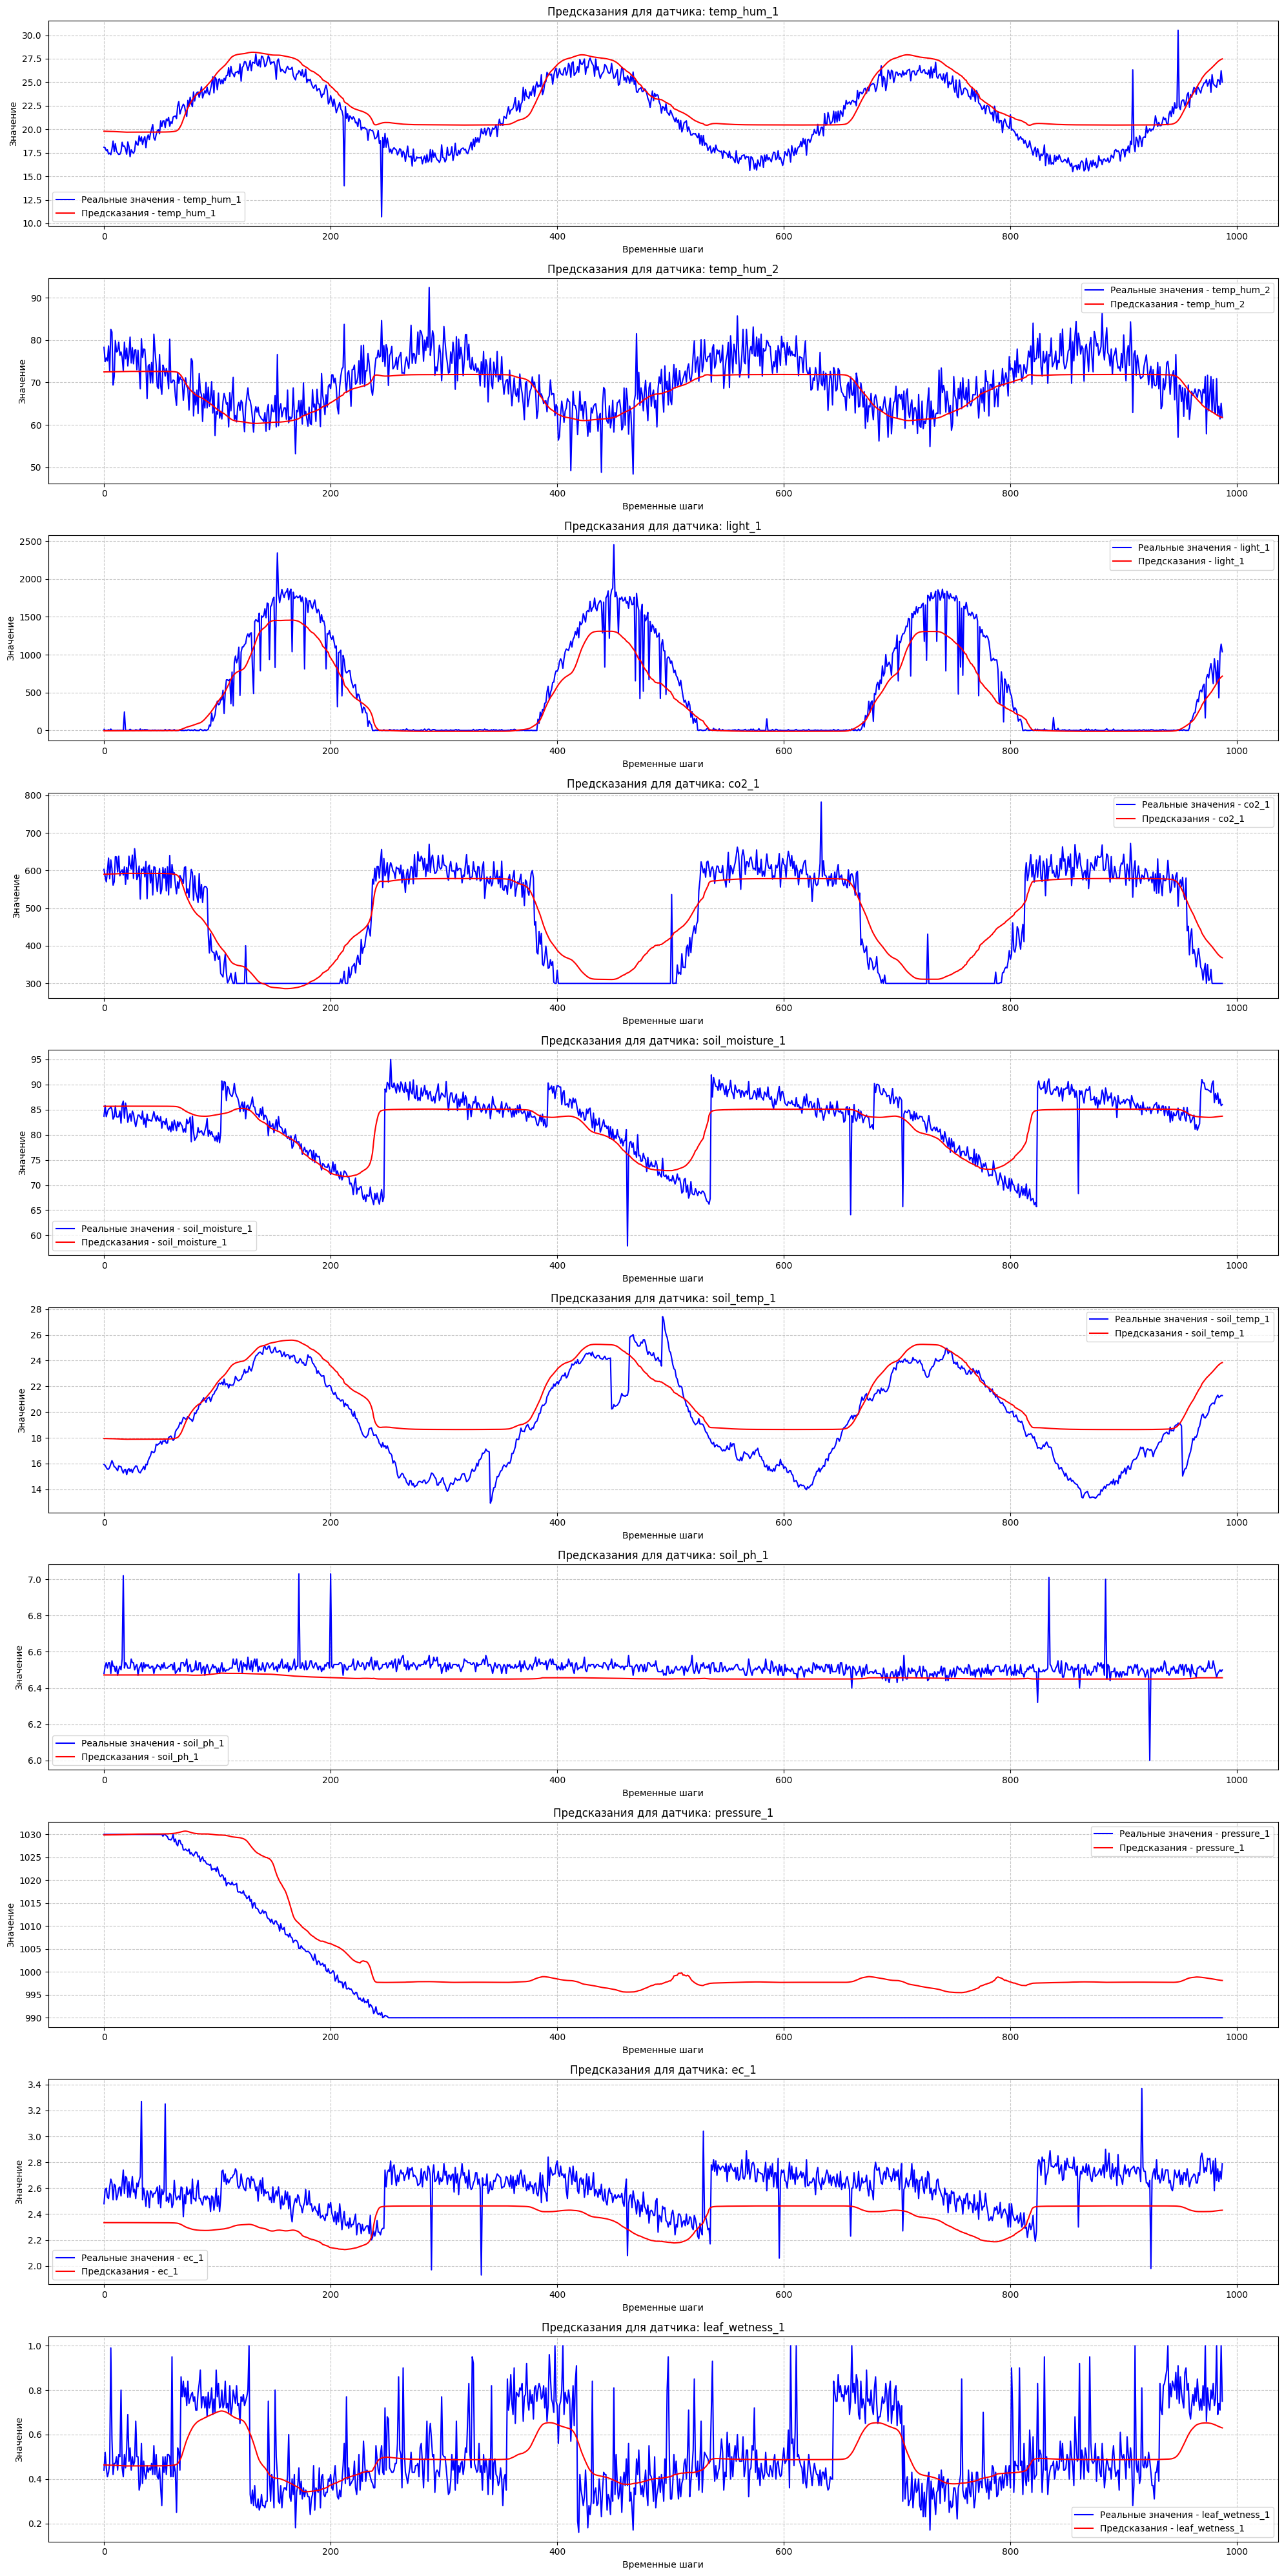

In [6]:
# График предсказаний по тестовой выборке

plt.figure(figsize=(20, 40))
for i, sensor_name in enumerate(sensor_columns):
    plt.subplot(len(sensor_columns), 1, i+1)
    
    plt.plot(y_test_inverse[:, i], 'b-', label=f'Реальные значения - {sensor_name}')
    plt.plot(predictions_inverse[:, i], 'r-', label=f'Предсказания - {sensor_name}')
    
    plt.title(f'Предсказания для датчика: {sensor_name}')
    plt.xlabel('Временные шаги')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()

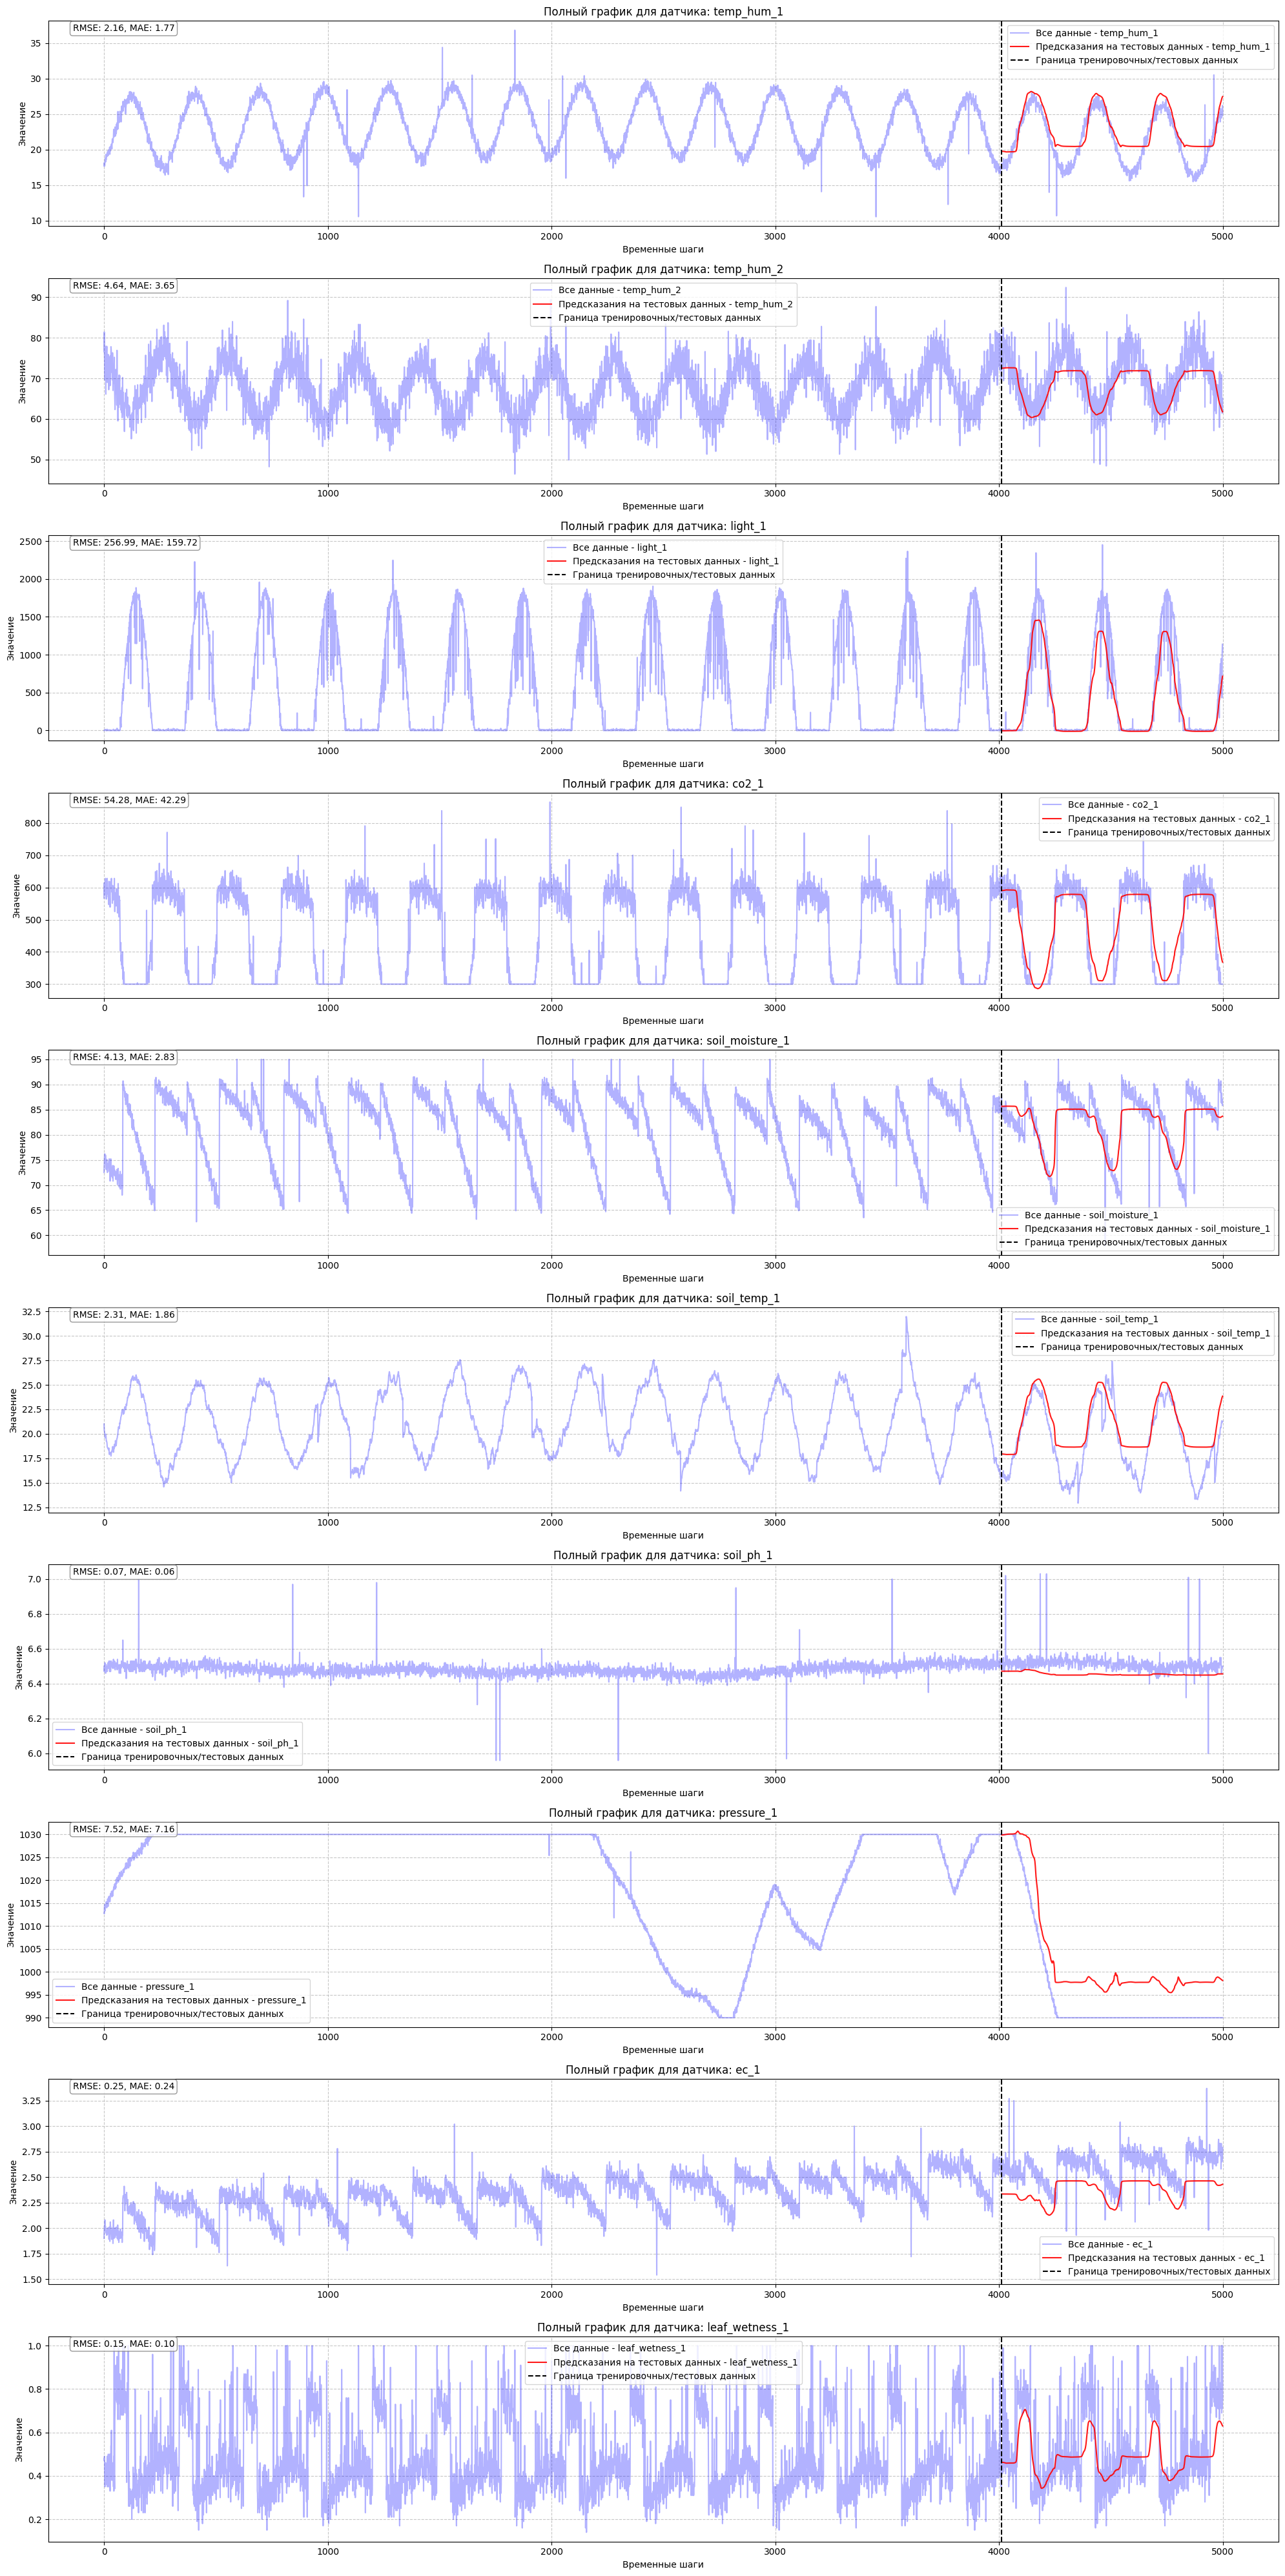

In [7]:
# Построение полных графиков с тренировочными данными
full_data = sensor_data
train_size = len(y_train) + seq_length
test_size = len(y_test)

# Индексы для отображения на графике
test_indices = range(train_size, train_size + test_size)

plt.figure(figsize=(20, 40))
for i, sensor_name in enumerate(sensor_columns):
    plt.subplot(len(sensor_columns), 1, i+1)
    
    # Построение всех реальных данных
    plt.plot(full_data[:, i], 'b-', alpha=0.3, label=f'Все данные - {sensor_name}')
    
    # Построение предсказаний для тестовых данных (несглаженные)
    plt.plot(test_indices, predictions_inverse[:, i], 'r-', alpha=0.9,
             label=f'Предсказания на тестовых данных - {sensor_name}')
    
    # Вертикальная линия, разделяющая тренировочные и тестовые данные
    plt.axvline(x=train_size, color='k', linestyle='--', label='Граница тренировочных/тестовых данных')
    
    # Установка параметров графика
    plt.title(f'Полный график для датчика: {sensor_name}')
    plt.xlabel('Временные шаги')
    plt.ylabel('Значение')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Находим соответствующую метрику
    for metric in metrics_data:
        if metric['Датчик'] == sensor_name:
            metrics_text = f"RMSE: {metric['RMSE']:.2f}, MAE: {metric['MAE']:.2f}"
            plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction', 
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
            break

plt.tight_layout()
# plt.savefig('full_sensor_predictions_no_smoothing.png', dpi=200)
plt.show()

In [8]:
# Сохранение модели
import os
import joblib
from tensorflow.keras.models import load_model

os.makedirs('model', exist_ok=True)

model.save(os.path.join('model', 'greenhouse_lstm_model.h5'))

joblib.dump(scaler, os.path.join('model', 'greenhouse_scaler.joblib'))

model_info = {
    'seq_length': seq_length,
    'num_sensors': num_sensors,
    'sensor_columns': sensor_columns
}

joblib.dump(model_info, os.path.join('model', 'greenhouse_model_info.joblib'))

['model\\greenhouse_model_info.joblib']

# ИНФЕРЕНС

In [ ]:
scaler = joblib.load('model/greenhouse_scaler.joblib')
model_info = joblib.load('model/greenhouse_model_info.joblib')
model = load_model('model/greenhouse_lstm_model.h5')

df = df.sort_values('timestamp')

sensor_columns = model_info['sensor_columns']
sensor_data = df[sensor_columns].values
scaled_data = scaler.transform(sensor_data)


seq_length = model_info['seq_length']
split_idx = int(len(scaled_data) * 0.8)  
training_data = scaled_data[:split_idx]
last_60_records = training_data[-seq_length:]  

print("Форма последних 60 записей:", last_60_records.shape)

def predict_future(model, scaler, initial_sequence, steps_ahead):
    sequence = np.array(initial_sequence).reshape(1, seq_length, len(sensor_columns))
    predictions = []
    
    for _ in range(steps_ahead):
        
        next_step = model.predict(sequence)[0]
        predictions.append(next_step)        
        
        sequence = np.append(sequence[:, 1:, :], [[next_step]], axis=1)    
    
    predictions_inverse = scaler.inverse_transform(predictions)
    return predictions_inverse

steps_ahead = 500  
future_predictions = predict_future(model, scaler, last_60_records, steps_ahead)

print("Прогноз:")
for i, prediction in enumerate(future_predictions):
    print(f"Шаг {i+1}: {prediction}")

Форма последних 60 записей: (60, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

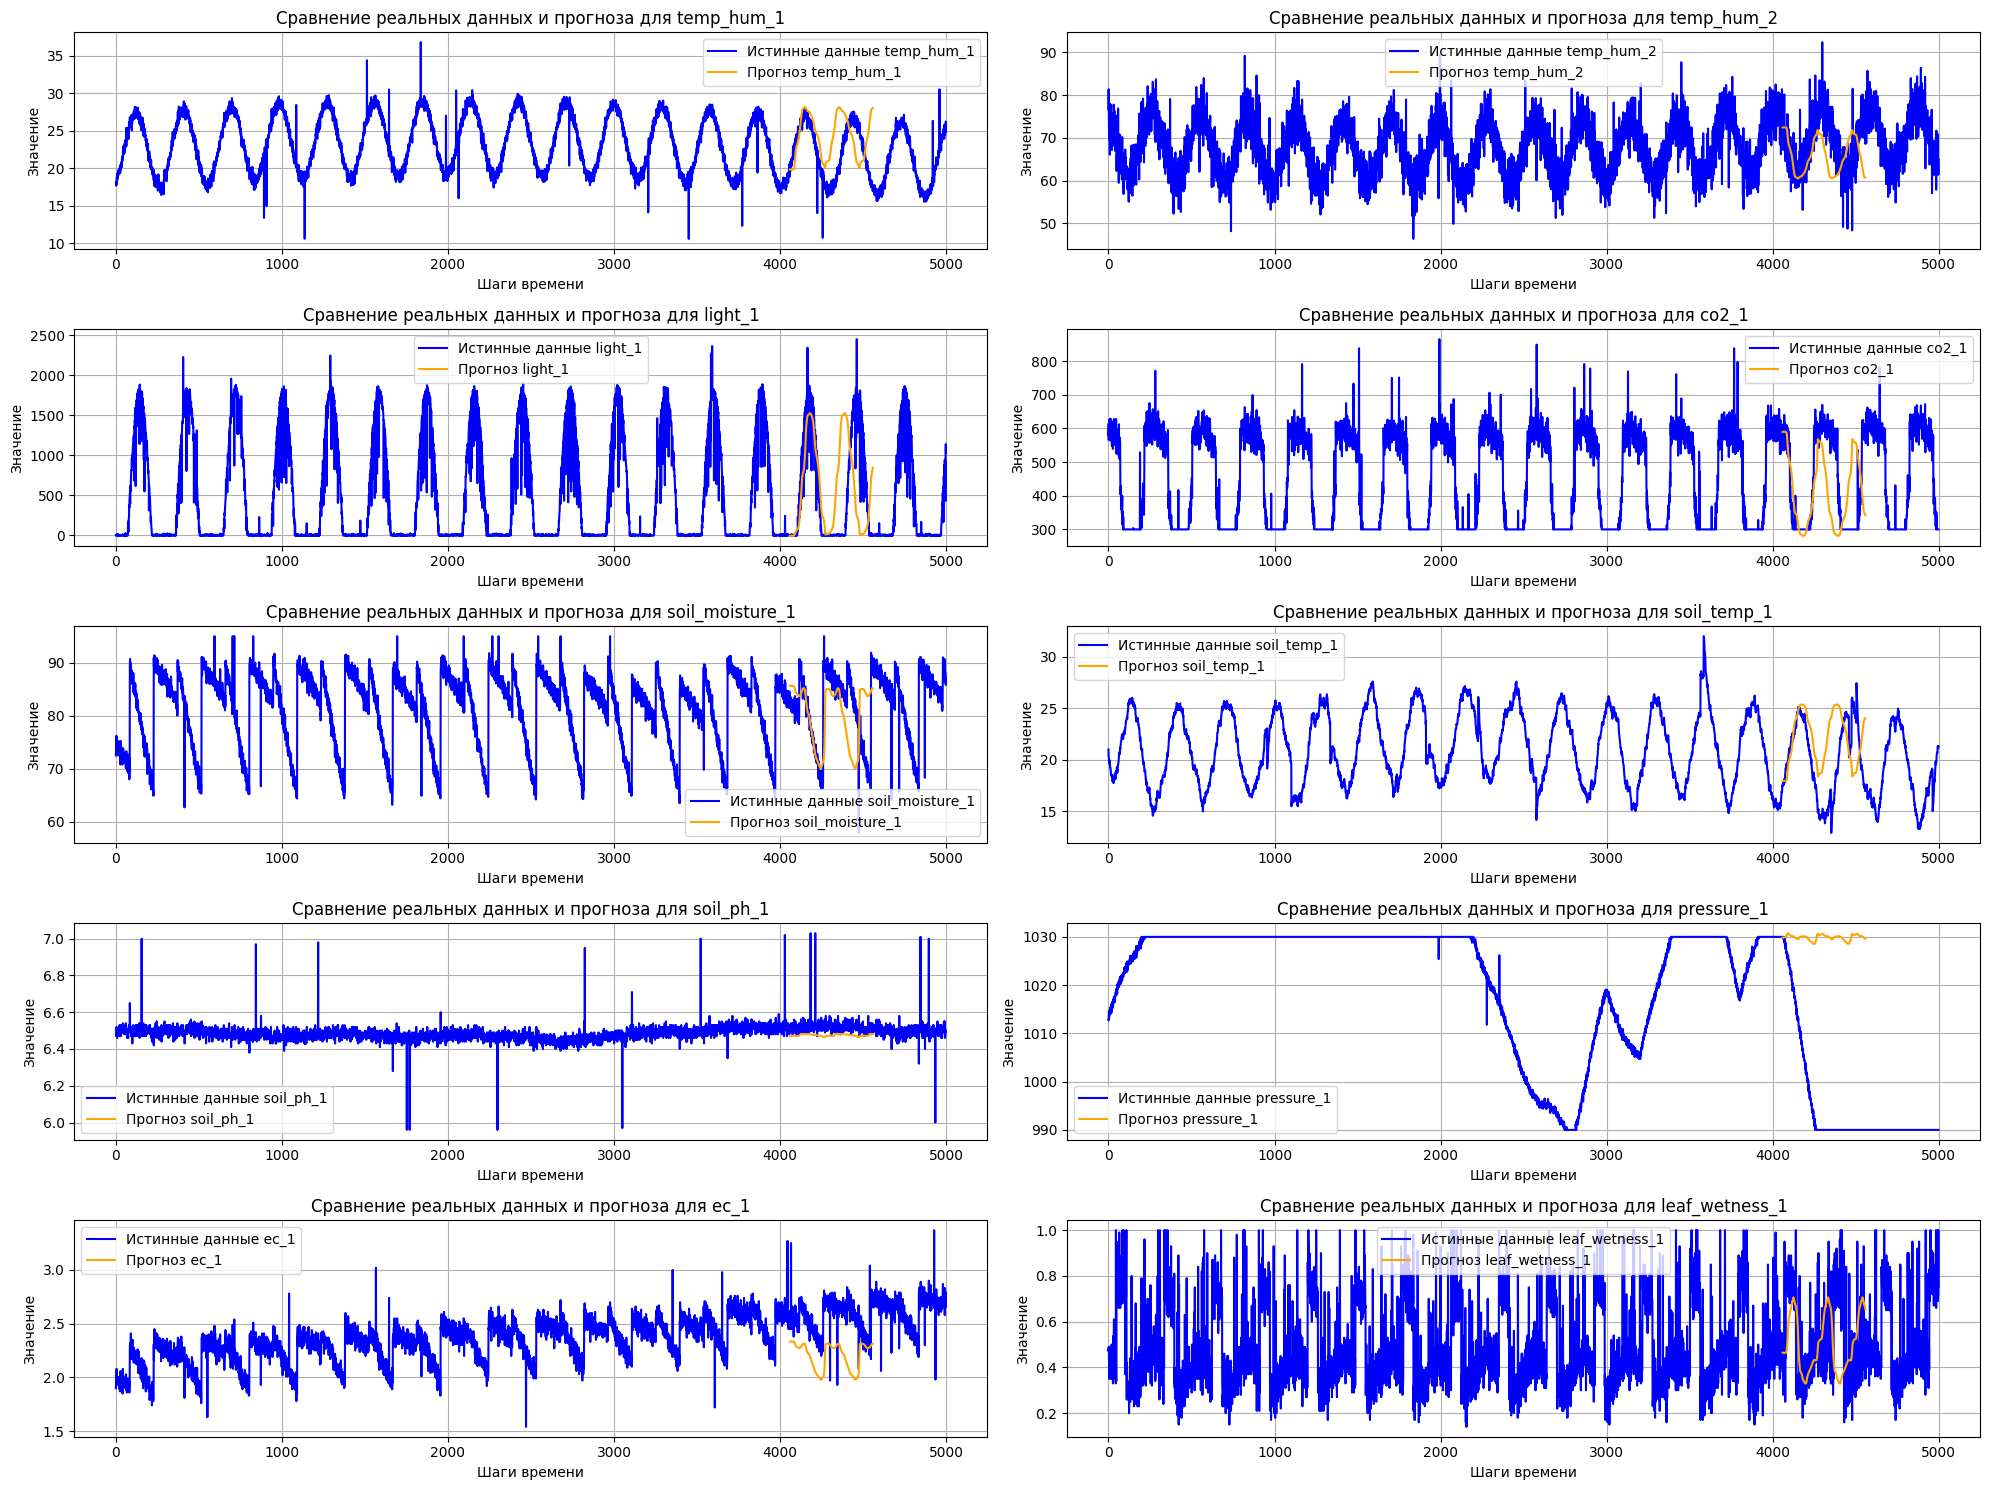

In [10]:
# Генерация графиков для каждого датчика в масштабе всего временного ряда
plt.figure(figsize=(20, 15))  # Увеличиваем размер фигуры для удобства отображения

for i, sensor_name in enumerate(sensor_columns):
    plt.subplot(5, 2, i + 1)  # Создаём сетку 5x2 для размещения 10 графиков
    
    # Отображение реальных значений (всего временного ряда)
    full_series_inverse = scaler.inverse_transform(scaled_data)[:, i]
    plt.plot(range(len(full_series_inverse)), full_series_inverse, label=f'Истинные данные {sensor_name}', color='blue')
    
    # Отображение прогнозируемых значений (начиная с конца тренировочной выборки)
    prediction_start_idx = split_idx + seq_length  # Индекс начала прогнозов на графике
    plt.plot(range(prediction_start_idx, prediction_start_idx + steps_ahead), 
             future_predictions[:, i], label=f'Прогноз {sensor_name}', color='orange')
    
    plt.title(f'Сравнение реальных данных и прогноза для {sensor_name}')
    plt.xlabel('Шаги времени')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid()

plt.tight_layout()  # Упорядочиваем расположение графиков
plt.show()

Размер последовательности после добавления записей: (60, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

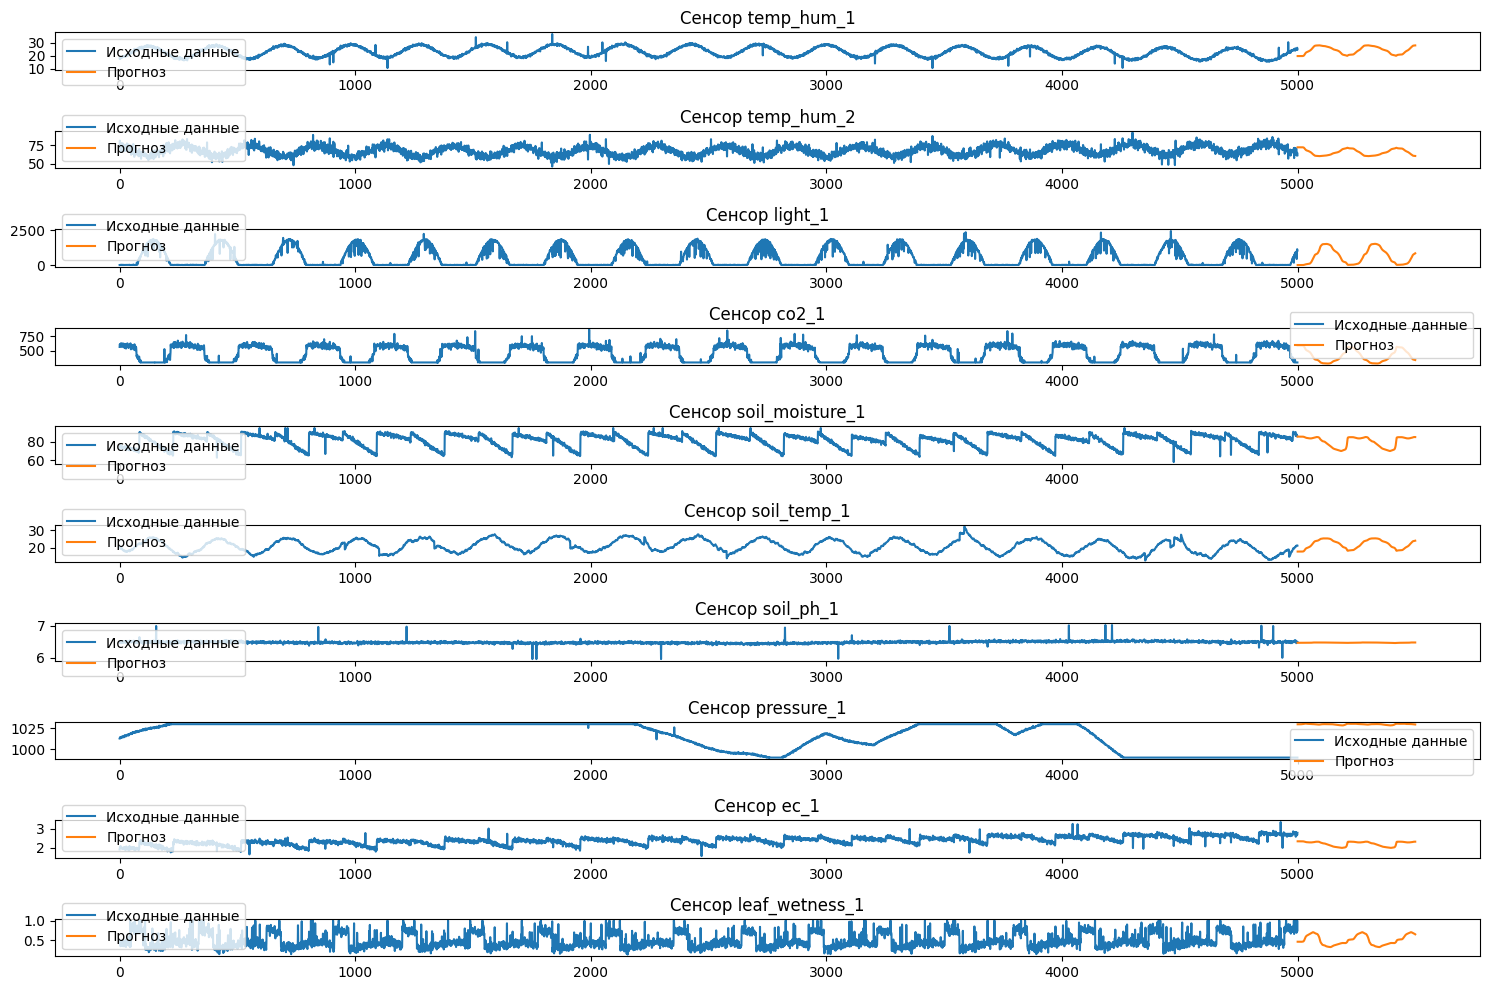

Прогноз на 500 шагов вперёд:
[[ 1.98256960e+01  7.24451679e+01 -4.90553438e+00 ...  1.02985765e+03
   2.33393174e+00  4.64648486e-01]
 [ 1.98222940e+01  7.24498098e+01 -4.96378816e+00 ...  1.02985438e+03
   2.33400482e+00  4.64467769e-01]
 [ 1.98130631e+01  7.24626689e+01 -4.94874992e+00 ...  1.02986011e+03
   2.33407932e+00  4.64010504e-01]
 ...
 [ 2.80075333e+01  6.07853257e+01  8.14423637e+02 ...  1.02969016e+03
   2.31397816e+00  6.61677219e-01]
 [ 2.80227628e+01  6.07590947e+01  8.27786944e+02 ...  1.02967585e+03
   2.31412977e+00  6.57537564e-01]
 [ 2.80410962e+01  6.07263739e+01  8.45393757e+02 ...  1.02965318e+03
   2.31421507e+00  6.51959041e-01]]


In [18]:
import numpy as np
import joblib
import json
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

scaler = joblib.load('model/greenhouse_scaler.joblib')
model_info = joblib.load('model/greenhouse_model_info.joblib')
model = load_model('model/greenhouse_lstm_model.h5')
model.compile(optimizer='adam', loss='mean_squared_error')

seq_length = model_info['seq_length']
num_sensors = len(model_info['sensor_columns'])
sensor_columns = model_info['sensor_columns']

sequence_file = 'current_sequence.json'
predictions_file = 'predictions.json'

def initialize_sequence():
    initial_sequence = np.zeros((seq_length, num_sensors))
    save_sequence(initial_sequence)

def load_sequence():
    with open(sequence_file, 'r') as f:
        sequence_json = json.load(f)
    sequence_array = np.array([[step[sensor] for sensor in sensor_columns] for step in sequence_json])
    return sequence_array

def save_sequence(sequence):
    sequence_json = []
    for i, step in enumerate(sequence):
        sequence_json.append({
            "seq_id": str(i + 1),
            **{sensor: float(step[j]) for j, sensor in enumerate(sensor_columns)}
        })
    with open(sequence_file, 'w') as f:
        json.dump(sequence_json, f, indent=4)

def save_predictions(predictions):
    predictions_json = []
    for i, prediction in enumerate(predictions):
        predictions_json.append({
            "step": str(i + 1),
            **{sensor: float(prediction[j]) for j, sensor in enumerate(sensor_columns)}
        })
    with open(predictions_file, 'w') as f:
        json.dump(predictions_json, f, indent=4)

def add_records_to_sequence(records):
    sequence = load_sequence()
    for record in records:
        sequence = np.append(sequence[1:], [record], axis=0)
    save_sequence(sequence)
    print(f"Размер последовательности после добавления записей: {sequence.shape}")

def predict_n_steps(n_steps):
    sequence = load_sequence()
    predictions = []
    
    for _ in range(n_steps):
        sequence_input = sequence.reshape(1, seq_length, num_sensors)
        prediction_scaled = model.predict(sequence_input)[0]
        predictions.append(prediction_scaled)
        sequence = np.append(sequence[1:], [prediction_scaled], axis=0)

    save_sequence(sequence)
    predictions_original = scaler.inverse_transform(predictions)
    save_predictions(predictions_original)
    return predictions_original

df = df.sort_values('timestamp')
sensor_data = df[sensor_columns].values
scaled_data = scaler.transform(sensor_data)

split_idx = int(len(scaled_data) * 0.8)
training_data = scaled_data[:split_idx]
last_60_records = training_data[-seq_length:]

initialize_sequence()
add_records_to_sequence(last_60_records)

n_steps = 500
predictions = predict_n_steps(n_steps)

plt.figure(figsize=(15, 10))
for i in range(num_sensors):
    plt.subplot(num_sensors, 1, i+1)
    plt.plot(range(len(sensor_data)), sensor_data[:, i], label='Исходные данные')
    plt.plot(range(len(sensor_data), len(sensor_data) + n_steps), predictions[:, i], label='Прогноз')
    plt.title(f'Сенсор {sensor_columns[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Прогноз на {n_steps} шагов вперёд:")
print(predictions)
